# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:  *Alejandro Rodriguez*

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [5]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [6]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [14]:
print(nhanes_scaled.dtypes)

DR1DRSTZ     float64
DR1EXMER     float64
DRABF        float64
DRDINT       float64
DR1DBIH      float64
              ...   
SMQ870       float64
SMQ872       float64
SMQ874       float64
SMQ878       float64
SMAQUEX.x    float64
Length: 241, dtype: object


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

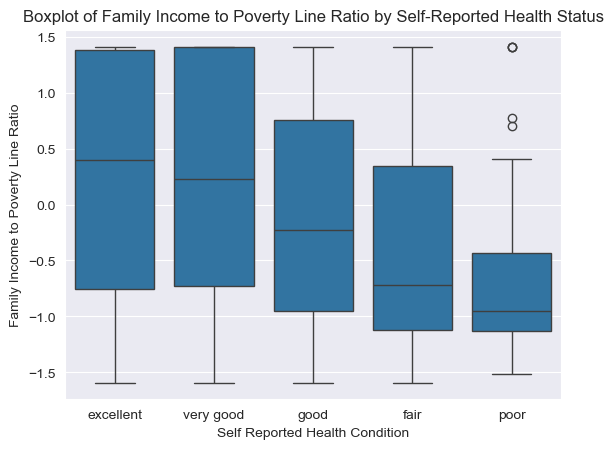

In [7]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

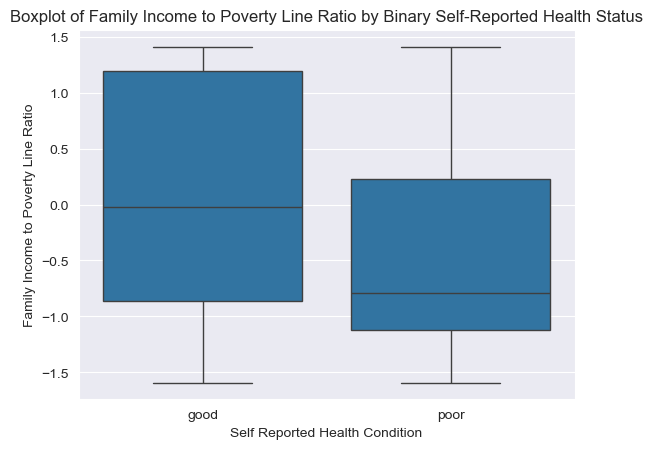

In [8]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

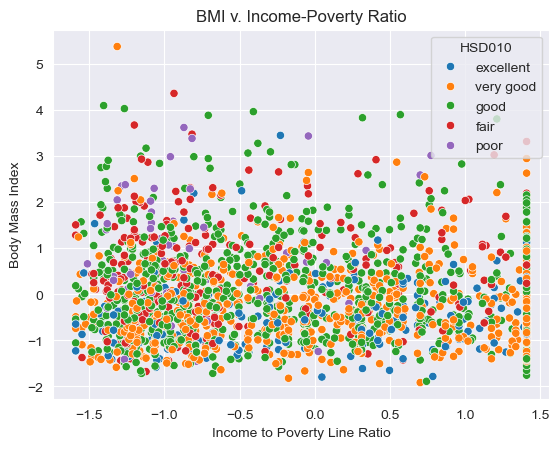

In [9]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [10]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [19]:
## Your Answer Here
# apply PCA
# ----------
pca = PCA(n_components=4)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3',
                                 'principal component 4'])
pca_df.head()                                 

,principal component 1,principal component 2,principal component 3,principal component 4
0,9.527811,-0.816226,1.867117,-2.108207
1,-5.838339,-3.692574,-3.805722,-1.027715
2,-0.719454,-2.573201,-0.907860,-4.754975
3,3.533627,-2.576983,3.249107,-0.404453
4,-6.872094,-4.194241,-0.886809,-0.849215


### Barplot of Components

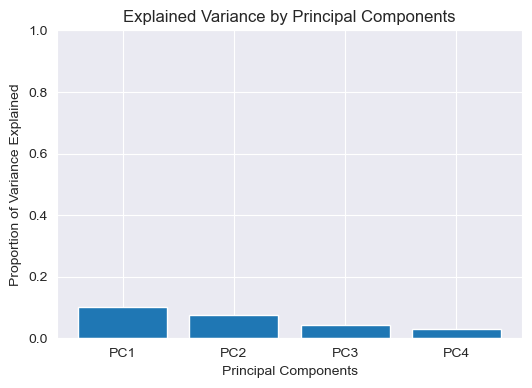

In [20]:
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.bar(
    ['PC1', 'PC2','PC3','PC4'],
    explained_var
)
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Components')
plt.title('Explained Variance by Principal Components')
plt.ylim(0, 1)

plt.show()

In [23]:
print("Explained variance ratio:", explained_var)
print("Total variance explained:", explained_var.sum())

Explained variance ratio: [0.10201961 0.07623011 0.04371192 0.02882171]
Total variance explained: 0.25078335589476686


### How many components will you use to fit a supervised learning model?

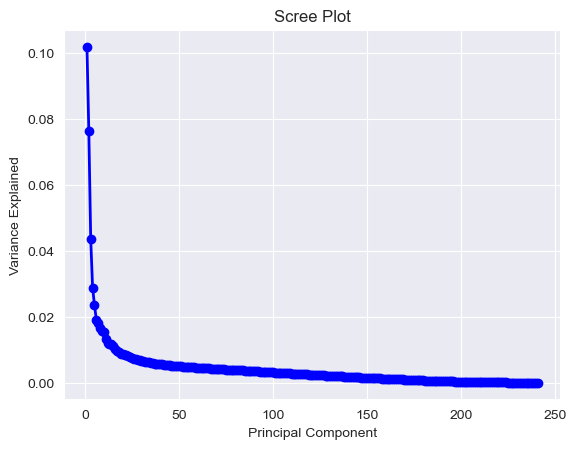

In [24]:
## Your Answer Here
#
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

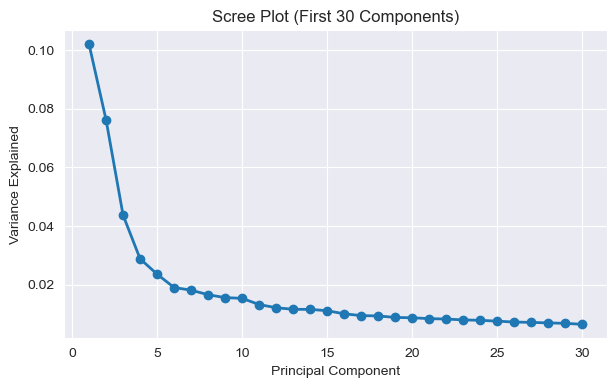

In [25]:
plt.figure(figsize=(7,4))
plt.plot(
    PC_values[:30],
    pca_all.explained_variance_ratio_[:30],
    'o-', linewidth=2
)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot (First 30 Components)')
plt.show()


From the scree plot I can see the elbow getting flatter after 5 components so I will keep 5 PCs to fit a supervised learning model.

In [37]:
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(nhanes_scaled)

pca_5_df = pd.DataFrame(
    X_pca_5,
    columns=[f'PC{i+1}' for i in range(5)]
)

### 2D Scatterplot of the first two components

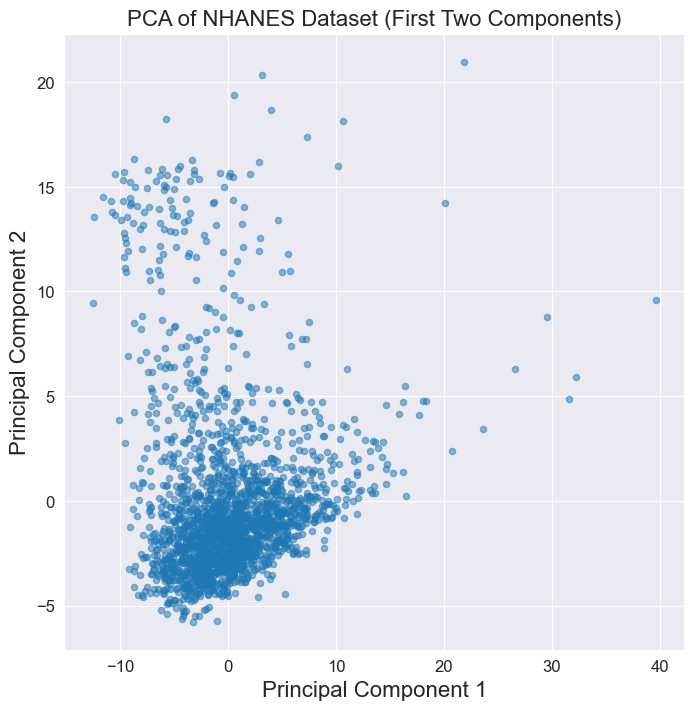

In [38]:
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('PCA of NHANES Dataset (First Two Components)', fontsize=16)

plt.scatter(
    pca_df['principal component 1'],
    pca_df['principal component 2'],
    alpha=0.5,
    s=20
)

plt.show()


The PCA scatterplot shows a dense central cluster with several outliers extending primarily along the first principal component. This indicates that PC1 captures large variation associated with extreme observations, while the majority of individuals exhibit more moderate and continuous variation aroun 0 in pC1 and around -2 in PC2. The absence of sharp clusters indicates that multiple components are likely needed to capture meaningful structure in the data.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will try K-Means because the PCA scatterplot shows a dense, continuous cloud of observations without clear nonlinear boundaries, which aligns well with K-means’ assumption of roughly convex clusters in low-dimensional space. Also, K-means scales efficiently to large datasets like NHANES one and integrates naturally with PCA by clustering on the principal component scores.

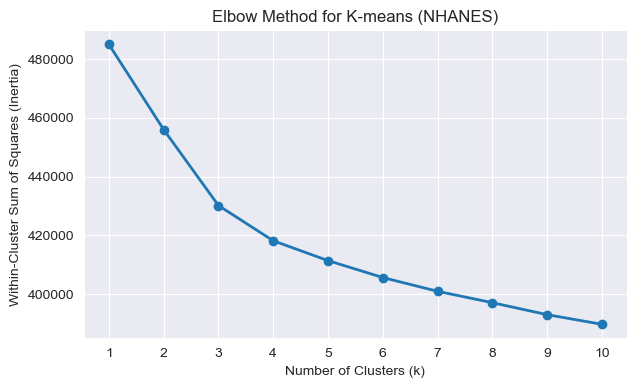

In [27]:
inertia = []
K = range(1, 11)  # try k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(nhanes_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for K-means (NHANES)')
plt.xticks(K)
plt.show()

We select the number of clusters using the elbow method, identifying that k=6 works because additional clusters yield only marginal reductions in within-cluster variance

### Cluster nhanes

In [29]:
## Your Answer Here
k=6
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
nhanes['cluster_k6'] = kmeans.fit_predict(nhanes_scaled)
nhanes['cluster_k6'].value_counts().sort_index()


cluster_k6
0    397
1    149
2    444
3    401
4    640
5     33
Name: count, dtype: int64

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

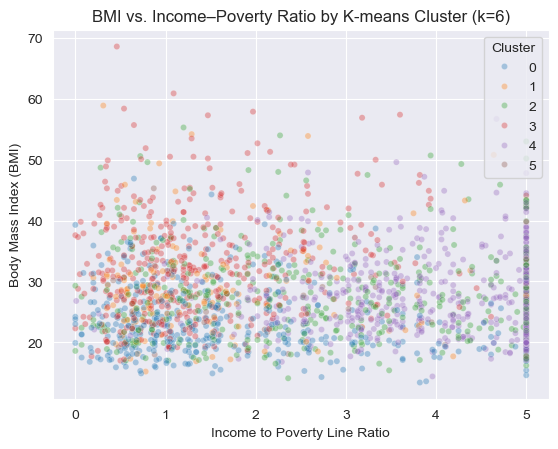

In [36]:
ax = sns.scatterplot(
    x="INDFMPIR",
    y="BMXBMI",
    hue="cluster_k6",
    data=nhanes,
    palette="tab10",
    alpha=0.35,
    s=20,
    legend="brief"
)

ax.set(
    xlabel="Income to Poverty Line Ratio",
    ylabel="Body Mass Index (BMI)",
    title="BMI vs. Income–Poverty Ratio by K-means Cluster (k=6)"
)
plt.legend(title="Cluster")
plt.show()


The BMI–income scatterplot reveals heterogeneity across clusters. The clusters show substantial overlap in the BMI–income space, indicating that no single socioeconomic variable drives the clustering structure. This suggests that the K-means clusters capture multidimensional health and nutritional profiles that cannot be explained by BMI and income alone.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [39]:
## Your Answer Here

k = 6
kmeans_pca = KMeans(n_clusters=k, random_state=1, n_init=10)
pca_5_df['cluster_pca'] = kmeans_pca.fit_predict(pca_5_df)

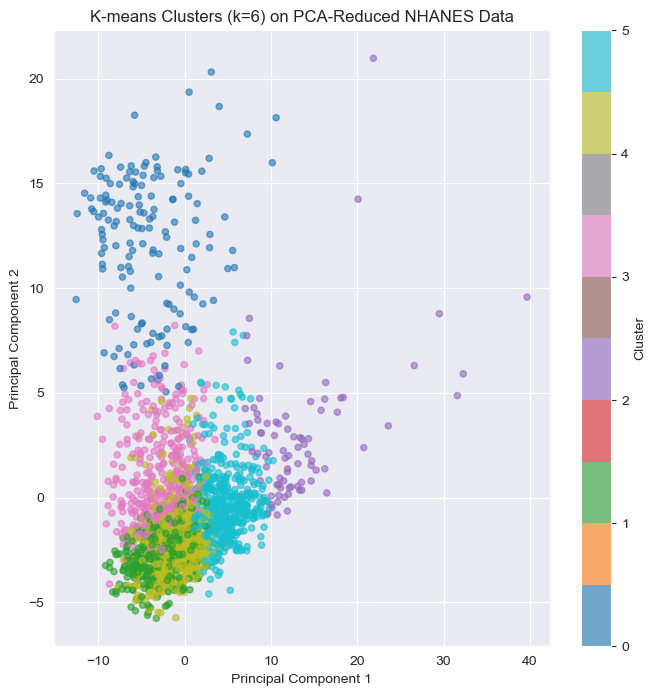

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(
    pca_5_df['PC1'],
    pca_5_df['PC2'],
    c=pca_5_df['cluster_pca'],
    cmap='tab10',
    alpha=0.6,
    s=20
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clusters (k=6) on PCA-Reduced NHANES Data')
plt.colorbar(label='Cluster')
plt.show()


Clustering on the first five principal components produces more compact and better-separated groups in the PC1–PC2 space, indicating that the dominant sources of variation meaningfully organize the data. One cluster extends far to the right along PC1, capturing high-leverage or extreme profiles, while others form compact, overlapping groups near the origin, suggesting distinct but partially continuous health–nutrition patterns rather than sharply discrete populations.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [47]:
nhanes.head(3)
#hsd010.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,cluster_k6
0,1,87,2,2,12,7,1,1,13,1,...,2,2,1,2,1,1,2,2,2,2
1,1,49,2,1,23,6,1,1,13,4,...,2,1,1,2,1,1,2,1,1,0
2,1,59,2,2,34,1,1,1,13,1,...,2,1,2,1,1,2,1,1,1,0


In [ ]:
# partition data
# -----------
y = hsd010.astype(int) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes # drop out any columns that aren't features but 'HSD010', 'SEQN' where already dropped

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10,
                                                    stratify=y)
                                                    

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train - 1, num_classes)
y_test = keras.utils.to_categorical(y_test - 1, num_classes)
num_classes = y_test.shape[1]

In [51]:
# create neural network model
# -----------
model = Sequential()

# input + first hidden layer
model.add(Dense(64, input_dim= X_train_scaled.shape[1], kernel_initializer= 'he_normal', activation= 'relu'))

model.add(Dense(32, kernel_initializer= 'he_normal', activation= 'relu'))

## Add any additional layers you wish here
# output layer (5-class classification)
model.add(Dense(5,activation='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=30, batch_size=32, verbose=1)

c:\Users\admin\anaconda3\envs\CSS\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3495 - loss: 1.5117 - val_accuracy: 0.4147 - val_loss: 1.4036
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4839 - loss: 1.2027 - val_accuracy: 0.4612 - val_loss: 1.3569
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5549 - loss: 1.0674 - val_accuracy: 0.4457 - val_loss: 1.3495
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6001 - loss: 0.9626 - val_accuracy: 0.4438 - val_loss: 1.3438
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6596 - loss: 0.8630 - val_accuracy: 0.4554 - val_loss: 1.3539
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7028 - loss: 0.7797 - val_accuracy: 0.4535 - val_loss: 1.3671
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7506 - loss: 0.6923 - val_accuracy: 0.4535 - val_loss: 1.3939
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7984 - loss: 0.6146 - val_accuracy: 0.4593 - val_loss

In [52]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.421


### Neural Network on Principal Components

In [53]:
## Your Answer Here

X = X_pca_5   # <-- PCA features only (shape: n_samples × 5)

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=10,
    stratify=y
)
y_train = to_categorical(y_train_raw - 1, num_classes=5)
y_test = to_categorical(y_test_raw - 1, num_classes=5)

# create neural network model
# -----------
model_pca = Sequential()

# input + hidden layer
model_pca.add(Dense(
    32,
    input_dim=5,                 # <-- ONLY 5 PCA FEATURES
    kernel_initializer='he_normal',
    activation='relu'
))

# optional second hidden layer
model_pca.add(Dense(
    16,
    kernel_initializer='he_normal',
    activation='relu'
))

# output layer
model_pca.add(Dense(
    5,
    activation='softmax'
))

model_pca.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_pca.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)
loss, acc = model_pca.evaluate(X_test, y_test, verbose=0)
print(f"PCA-only model accuracy: {acc:.3f}")

Epoch 1/30


c:\Users\admin\anaconda3\envs\CSS\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3385 - loss: 2.2603 - val_accuracy: 0.3721 - val_loss: 1.8215
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3895 - loss: 1.6938 - val_accuracy: 0.4186 - val_loss: 1.5997
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4205 - loss: 1.4983 - val_accuracy: 0.4128 - val_loss: 1.4843
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4309 - loss: 1.3999 - val_accuracy: 0.4322 - val_loss: 1.4220
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4406 - loss: 1.3374 - val_accuracy: 0.4457 - val_loss: 1.3798
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4509 - loss: 1.2987 - val_accuracy: 0.4399 - val_loss: 1.3636
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4528 - loss: 1.2761 - val_accuracy: 0.4360 - val_loss: 1.3491
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4574 - loss: 1.2584 - val_accuracy: 0.4322 - val_loss: 1.3402


### Neural Network on Principal Components + Cluster Membership

Build the feature matrix: PCA + cluster membership:

In [57]:
clusters = pca_5_df['cluster_pca'].values.reshape(-1, 1)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

clusters_ohe = encoder.fit_transform(clusters)
X = np.hstack([X_pca_5, clusters_ohe])

In [58]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=10,
    stratify=y
)

y_train = to_categorical(y_train_raw - 1, num_classes=5)
y_test = to_categorical(y_test_raw - 1, num_classes=5)

In [59]:
model_pca_cluster = Sequential()

model_pca_cluster.add(Dense(
    32,
    input_dim=X.shape[1],   # <-- PCA + cluster features
    kernel_initializer='he_normal',
    activation='relu'
))

model_pca_cluster.add(Dense(
    16,
    kernel_initializer='he_normal',
    activation='relu'
))

model_pca_cluster.add(Dense(
    5,
    activation='softmax'
))

model_pca_cluster.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_pca_cluster.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

loss, acc = model_pca_cluster.evaluate(X_test, y_test, verbose=0)
print(f"PCA + cluster model accuracy: {acc:.3f}")


c:\Users\admin\anaconda3\envs\CSS\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2410 - loss: 2.6654 - val_accuracy: 0.2946 - val_loss: 1.8274
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3572 - loss: 1.6594 - val_accuracy: 0.3818 - val_loss: 1.5940
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3831 - loss: 1.4759 - val_accuracy: 0.4167 - val_loss: 1.4759
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4154 - loss: 1.3894 - val_accuracy: 0.4070 - val_loss: 1.4258
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4283 - loss: 1.3389 - val_accuracy: 0.4167 - val_loss: 1.3890
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4425 - loss: 1.3075 - val_accuracy: 0.4109 - val_loss: 1.3583
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4587 - loss: 1.2802 - val_accuracy: 0.4186 - val_loss: 1.3367
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4632 - loss: 1.2628 - val_accuracy: 0.4399 - val_l

The neural network using the original features achieved the lowest accuracy, suggesting that the high dimensionality and redundancy in the raw NHANES variables make it harder for the model to generalize. Using only the first five PCA components led to the best performance, indicating that PCA effectively removes noise and captures the most important structure in the data. Adding cluster membership to the PCA features did not further improve accuracy, likely because the clusters summarize information already contained in the principal components (K-means clusters are derived from the same PCA space and result in redundant information). Overall, I would choose the PCA-only featurization because it provides the highest accuracy while using a simpler and more compact representation of the data.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA and clustering serve different purposes. PCA is a dimensionality-reduction technique based on linear algebra that creates new variables (principal components) which summarize the main patterns of variation in high-dimensional data, making the data easier to analyze and visualize. Clustering, in contrast, does not create new dimensions; instead, it groups observations within the existing feature space based on similarity or distance, with the goal of identifying subsets of data points that are more similar to each other than to the rest of the dataset.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I did not see a clear advantage from combining PCA and clustering in this case. While PCA can summarize the main patterns in the data and, in principle, provide a cleaner input for clustering, the PCA results for this dataset did not reveal strong or well-separated structure. As a result, the clusters largely reflected information already captured by the principal components, and adding cluster membership did not introduce meaningful new signal. This suggests that the underlying variation in the NHANES data is mostly continuous rather than organized into distinct groups, limiting the gains from combining these two methods.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"


Unsupervised techniques can support downstream supervised learning by simplifying complex, high-dimensional data before modeling. Methods like PCA handle multicollinearity by collapsing groups of highly correlated features into a smaller number of components, which can stabilize training and reduce overfitting, especially in big data settings. Clustering and other unsupervised approaches can also provide more interpretable results, and reveal meaning  patterns or latent structures in data that help us understand and explain what the supervised model is predicting based on.